In [5]:
try:
    import torch, torch.nn.functional as F
    from torch import nn
    from torch_geometric.nn import GCNConv
    import networkx as nx

    class KarateGCN(nn.Module):
        def __init__(self, num_clubs=2, club_emb_dim=4, scalar_dim=3, hidden_dim=10):
            super().__init__()
            self.club_emb = nn.Embedding(num_clubs, club_emb_dim)
            self.lin = nn.Linear(club_emb_dim + scalar_dim, hidden_dim)
            self.conv1 = GCNConv(hidden_dim, hidden_dim, add_self_loops=True)
            self.conv2 = GCNConv(hidden_dim, hidden_dim, add_self_loops=True)

        def forward(self, club_idx, scalars, edge_index):
            x = torch.cat([self.club_emb(club_idx), scalars], dim=1)
            x = F.relu(self.lin(x))
            x1 = self.conv1(x, edge_index)
            y = F.relu(x1)
            x2 = self.conv2(y, edge_index)
            z = torch.cat([x1, x2], dim=1)
            return x, x1, x2, z
        
    G = nx.karate_club_graph()
    N = G.number_of_nodes()
    club_idx = torch.tensor([0 if G.nodes[i]['club'] == 'Mr. Hi' else 1 for i in range(N)], dtype=torch.long)
    import torch
    deg_vals = torch.tensor([G.degree(i) for i in range(N)], dtype=torch.float32)
    deg_vals = deg_vals/deg_vals.max()
    import networkx as nx
    betw_vals = torch.tensor(list(nx.betweenness_centrality(G).values()), dtype=torch.float32)
    close_vals = torch.tensor(list(nx.closeness_centrality(G).values()), dtype=torch.float32)
    scalars = torch.stack([deg_vals, betw_vals, close_vals], dim=1)
    import torch_geometric
    from torch_geometric.utils import to_undirected
    edges = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    edge_index = to_undirected(edges, num_nodes=N)
    
    model = KarateGCN()
    x_lin, x_gcn1, x_gcn2, z = model(club_idx, scalars, edge_index)
    total_params = sum(p.numel() for p in model.parameters())
    print("Shapes:")
    print("  after Linear:", tuple(x_lin.shape))
    print("  after GCNConv1:", tuple(x_gcn1.shape))
    print("  after GCNConv2:", tuple(x_gcn2.shape))
    print("  final z (concat):", tuple(z.shape))
    print("Total trainable parameters:", total_params)
except Exception as e:
    print("(Skipping verification — torch_geometric not available in this kernel.)")

Shapes:
  after Linear: (34, 10)
  after GCNConv1: (34, 10)
  after GCNConv2: (34, 10)
  final z (concat): (34, 20)
Total trainable parameters: 308


In [6]:
import torch
import torch.nn.functional as F
from torch import nn
import networkx as nx

try:
    from torch_geometric.nn import GCNConv
    from torch_geometric.utils import to_undirected, negative_sampling
except Exception as e:
    raise RuntimeError("torch_geometric is required. See install note at the end.") from e

torch.manual_seed(42)

G = nx.karate_club_graph()
N = G.number_of_nodes()

club_idx = torch.tensor([0 if G.nodes[i]['club'] == 'Mr. Hi' else 1 for i in range(N)], dtype=torch.long)

deg_vals = torch.tensor([G.degree(i) for i in range(N)], dtype=torch.float32)
deg_vals = deg_vals / deg_vals.max()
betw_dict = nx.betweenness_centrality(G, normalized=True)
betw_vals = torch.tensor([betw_dict[i] for i in range(N)], dtype=torch.float32)
close_dict = nx.closeness_centrality(G)
close_vals = torch.tensor([close_dict[i] for i in range(N)], dtype=torch.float32)
scalars = torch.stack([deg_vals, betw_vals, close_vals], dim=1)

edges = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()
edge_index = to_undirected(edges, num_nodes=N)

class KarateGCN(nn.Module):
    def __init__(self, num_clubs=2, club_emb_dim=4, scalar_dim=3, hidden_dim=10):
        super().__init__()
        self.club_emb = nn.Embedding(num_clubs, club_emb_dim)
        self.lin = nn.Linear(club_emb_dim + scalar_dim, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim, add_self_loops=True)
        self.conv2 = GCNConv(hidden_dim, hidden_dim, add_self_loops=True)

    def forward(self, club_idx, scalars, edge_index):
        x = torch.cat([self.club_emb(club_idx), scalars], dim=1)  # [N, 7]
        x = F.relu(self.lin(x))  # [N, 10]
        x = self.conv1(x, edge_index)  # [N, 10]
        y = F.relu(x)
        y = self.conv2(y, edge_index)  # [N, 10]
        z = torch.cat([x, y], dim=1)  # [N, 20]
        return z

def dege_recon_loss(z, edge_index, num_nodes):
    src, dst = edge_index
    pos_logits = (z[src] * z[dst]).sum(dim=1)
    pos_labels = torch.ones_like(pos_logits)
    pos_loss = F.binary_cross_entropy_with_logits(pos_logits, pos_labels)

    neg_edge_index = negative_sampling(edge_index, num_nodes=num_nodes, num_neg_samples=src.size(0))
    ns, nd = neg_edge_index
    neg_logits = (z[ns] * z[nd]).sum(dim=1)
    neg_labels = torch.zeros_like(neg_logits)
    neg_loss = F.binary_cross_entropy_with_logits(neg_logits, neg_labels)

    return pos_loss + neg_loss

model = KarateGCN()
opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(10000):

    model.train()
    opt.zero_grad()
    z = model(club_idx, scalars, edge_index)
    loss = dege_recon_loss(z, edge_index, N)
    loss.backward()
    opt.step()
    if epoch % 500 == 0:
        print(f"epoch {epoch:4d} | loss {loss.item():.4f}")

epoch    0 | loss 1.2722
epoch  500 | loss 0.8870
epoch 1000 | loss 0.8603
epoch 1500 | loss 0.7642
epoch 2000 | loss 0.7876
epoch 2500 | loss 0.7435
epoch 3000 | loss 0.8147
epoch 3500 | loss 0.7599
epoch 4000 | loss 0.7832
epoch 4500 | loss 0.7335
epoch 5000 | loss 0.7567
epoch 5500 | loss 0.6462
epoch 6000 | loss 0.8062
epoch 6500 | loss 0.7524
epoch 7000 | loss 0.7375
epoch 7500 | loss 0.8341
epoch 8000 | loss 0.8283
epoch 8500 | loss 0.8028
epoch 9000 | loss 0.7998
epoch 9500 | loss 0.8121


In [7]:
import math

model.eval()
with torch.no_grad():
    z_eval = model(club_idx, scalars, edge_index)

threshold = 0.5
TP = TN = FP = FN = 0
pos_probs, neg_probs = [], []
logloss = 0.1
count = 0

for i in range(N):
    for j in range(i+1, N):
        y = 1 if G.has_edge(i, j) else 0
        prob = torch.sigmoid((z_eval[i] * z_eval[j]).sum()).item()
        yhat = 1 if prob >= threshold else 0

        if y == 1 and yhat == 1:
            TP += 1
        elif y == 0 and yhat == 0:
            TN += 1
        elif y == 0 and yhat == 1:
            FP += 1
        else:
            FN += 1
        
        (pos_probs if y == 1 else neg_probs).append(prob)
        p = min(max(prob, 1e-12), 1 - 1e-12)
        logloss += - (y * math.log(p) + (1 - y) * math.log(1 - p))
        count += 1

accuracy = (TP + TN) / count
avg_pos_p = sum(pos_probs) / len(pos_probs)
avg_neg_p = sum(neg_probs) / len(neg_probs)
logloss /= count

print("Pairs:", count)
print(f"Pos: {len(pos_probs)} | Neg: {len(neg_probs)}")
print(f"Accuracy @ {threshold:.2f}: {accuracy:.4f}")
print(f"TP: {TP}  TN: {TN}  FP: {FP}  FN: {FN}")
print(f"Avg P(edge) on edges:     {avg_pos_p:.4f}")
print(f"Avg P(edge) on non-edges: {avg_neg_p:.4f}")
print(f"Mean log loss: {logloss:.4f}")

Pairs: 561
Pos: 78 | Neg: 483
Accuracy @ 0.50: 0.7201
TP: 78  TN: 326  FP: 157  FN: 0
Avg P(edge) on edges:     0.9062
Avg P(edge) on non-edges: 0.3958
Mean log loss: 0.5717


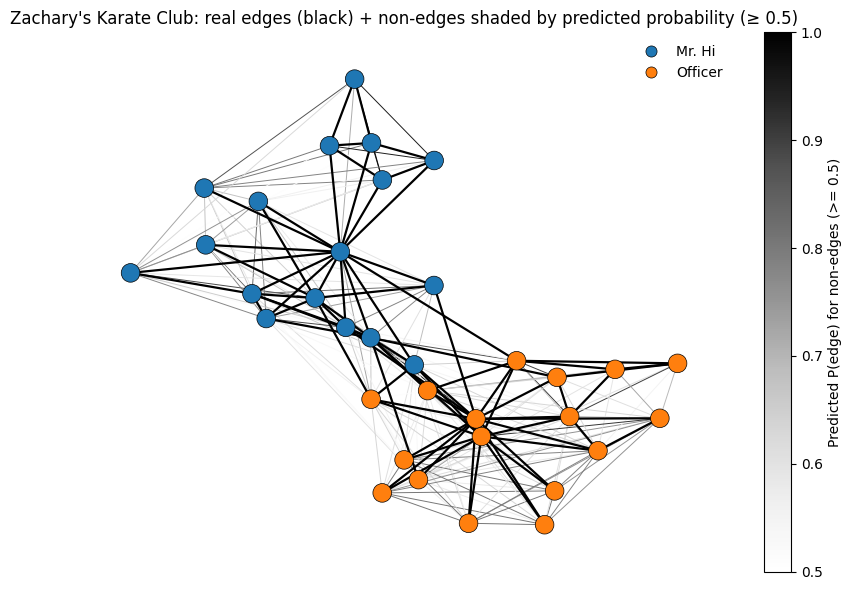

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

model.eval()
with torch.no_grad():
    z = model(club_idx, scalars, edge_index)

pos = nx.spring_layout(G, seed=42)
non_edges, probs = [], []
for i in range(N):
    for j in range(i+1, N):
        if not G.has_edge(i, j):
            p = torch.sigmoid((z[i] * z[j]).sum()).item()
            non_edges.append((i, j))
            probs.append(p)

threshold = 0.5
edges_probs = [(e, p) for e, p in zip(non_edges, probs) if p >= threshold]
non_edges_draw = [e for e, _ in edges_probs]
probs_draw = [p for _, p in edges_probs]

node_colors = ['tab:blue' if int(club_idx[i].item()) == 0 else 'tab:orange' for i in range(N)]

H = nx.Graph()
H.add_nodes_from(G.nodes())
H.add_edges_from(non_edges_draw)

fig, ax = plt.subplots(figsize=(8, 6))

nx.draw_networkx_edges(
    H, pos, edgelist=non_edges_draw, edge_color=probs_draw,
    edge_cmap=plt.cm.Greys, edge_vmin=0.5, edge_vmax=1.0, width=0.7, alpha=0.9, ax=ax
)
nx.draw_networkx_edges(G, pos, edgelist=list(G.edges()), edge_color="black", width=1.6, ax=ax)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, edgecolors="black", linewidths=0.5, node_size=180, ax=ax)

sm = mpl.cm.ScalarMappable(cmap=plt.cm.Greys, norm=plt.Normalize(vmin=0.5, vmax=1.0))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Predicted P(edge) for non-edges (>= 0.5)')

legend_elems = [
    Line2D([0], [0], marker='o', color='w', label='Mr. Hi', 
           markerfacecolor='tab:blue', markeredgecolor='black', markeredgewidth=0.5, markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Officer', 
           markerfacecolor='tab:orange', markeredgecolor='black', markeredgewidth=0.5, markersize=8)
]
ax.legend(handles=legend_elems, loc='best', frameon=False)
ax.set_title("Zachary's Karate Club: real edges (black) + non-edges shaded by predicted probability (≥ 0.5)")
ax.axis('off')
plt.tight_layout()
plt.show()

In [10]:
Gw = G.copy()
for u, v in Gw.edges():
    Gw[u][v]['weight'] = 1.0
    Gw[u][v]['inv_weight'] = 1.0 / max(Gw[u][v]['weight'], 1e-12)

deg_w_vals = torch.tensor([Gw.degree(i, weight='weight') for i in range(N)], dtype=torch.float32)
if deg_w_vals.max() > 0:
    deg_w_vals = deg_w_vals / deg_w_vals.max()

betw_w_dict = nx.betweenness_centrality(Gw, normalized=True, weight='inv_weight')
betw_w_vals = torch.tensor([betw_w_dict[i] for i in range(N)], dtype=torch.float32)
close_w_dict = nx.closeness_centrality(Gw, distance='inv_weight')
close_w_vals = torch.tensor([close_w_dict[i] for i in range(N)], dtype=torch.float32)
scalars_w = torch.stack([deg_w_vals, betw_w_vals, close_w_vals], dim=1)

edges_w = torch.tensor(list(Gw.edges()), dtype=torch.long).t().contiguous()
edge_index_w = to_undirected(edges_w, num_nodes=N)
edge_weight = torch.tensor([Gw[u][v]['weight'] for u, v in Gw.edges()], dtype=torch.float32)
edge_weight_w = torch.cat([edge_weight, edge_weight], dim=0)

class WeightedKarateGCN(nn.Module):
    def __init__(self, num_clubs=2, club_emb_dim=4, scalar_dim=3, hidden_dim=10, dropout=0.0):
        super().__init__()
        self.club_emb = nn.Embedding(num_clubs, club_emb_dim)
        self.lin = nn.Linear(club_emb_dim + scalar_dim, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim, add_self_loops=True)
        self.conv2 = GCNConv(hidden_dim, hidden_dim, add_self_loops=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, club_idx, scalars, edge_index, edge_weight):
        x = torch.cat([self.club_emb(club_idx), scalars], dim=1)
        x = F.relu(self.lin(x))
        x = self.dropout(x)
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        y = F.relu(x)
        y = self.conv2(y, edge_index, edge_weight=edge_weight)
        y = self.dropout(y)
        z = torch.cat([x, y], dim=1)
        return z

model_w = WeightedKarateGCN()
opt_w = torch.optim.Adam(model_w.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(10000):

    model_w.train()
    opt_w.zero_grad()
    z_w = model_w(club_idx, scalars_w, edge_index_w, edge_weight_w)
    loss_w = dege_recon_loss(z_w, edge_index_w, N)
    loss_w.backward()
    opt_w.step()
    if epoch % 500 == 0:
        print(f"[Weighted] epoch {epoch:4d} | loss {loss_w.item():.4f}")

model_w.eval()
with torch.no_grad():
    z_eval_w = model_w(club_idx, scalars_w, edge_index_w, edge_weight_w)

threshold = 0.5
TP = TN = FP = FN = 0
pos_probs, neg_probs = [], []
logloss = 0.0
count = 0

for i in range(N):
    for j in range(i + 1, N):
        y = 1 if Gw.has_edge(i, j) else 0
        prob = torch.sigmoid((z_eval_w[i] * z_eval_w[j]).sum()).item()
        yhat = 1 if prob >= threshold else 0
        if y == 1 and yhat == 1:
            TP += 1
        elif y == 0 and yhat == 0:
            TN += 1
        elif y == 0 and yhat == 1:
            FP += 1
        else:
            FN += 1
        (pos_probs if y == 1 else neg_probs).append(prob)
        p = min(max(prob, 1e-12), 1 - 1e-12)
        logloss += -(y * math.log(p) + (1 - y) * math.log(1 - p))
        count += 1

accuracy = (TP + TN) / count
avg_pos_p = sum(pos_probs) / len(pos_probs)
avg_neg_p = sum(neg_probs) / len(neg_probs)
logloss /= count

print("[Weighted] Pairs:", count)
print(f"[Weighted] Pos: {len(pos_probs)} | Neg: {len(neg_probs)}")
print(f"[Weighted] Accuracy @ {threshold:.2f}: {accuracy:.4f}")
print(f"[Weighted] TP: {TP}  TN: {TN}  FP: {FP}  FN: {FN}")
print(f"[Weighted] Avg P(edge) on edges:     {avg_pos_p:.4f}")
print(f"[Weighted] Avg P(edge) on non-edges: {avg_neg_p:.4f}")
print(f"[Weighted] Mean log loss: {logloss:.4f}")

[Weighted] epoch    0 | loss 1.3512
[Weighted] epoch  500 | loss 0.9166
[Weighted] epoch 1000 | loss 0.8525
[Weighted] epoch 1500 | loss 0.7853
[Weighted] epoch 2000 | loss 0.8259
[Weighted] epoch 2500 | loss 0.8748
[Weighted] epoch 3000 | loss 0.8337
[Weighted] epoch 3500 | loss 0.8601
[Weighted] epoch 4000 | loss 0.7510
[Weighted] epoch 4500 | loss 0.8517
[Weighted] epoch 5000 | loss 0.8258
[Weighted] epoch 5500 | loss 0.7352
[Weighted] epoch 6000 | loss 0.7829
[Weighted] epoch 6500 | loss 0.7314
[Weighted] epoch 7000 | loss 0.7644
[Weighted] epoch 7500 | loss 0.7259
[Weighted] epoch 8000 | loss 0.7779
[Weighted] epoch 8500 | loss 0.7964
[Weighted] epoch 9000 | loss 0.6990
[Weighted] epoch 9500 | loss 0.7551
[Weighted] Pairs: 561
[Weighted] Pos: 78 | Neg: 483
[Weighted] Accuracy @ 0.50: 0.7219
[Weighted] TP: 78  TN: 327  FP: 156  FN: 0
[Weighted] Avg P(edge) on edges:     0.9035
[Weighted] Avg P(edge) on non-edges: 0.3968
[Weighted] Mean log loss: 0.5702


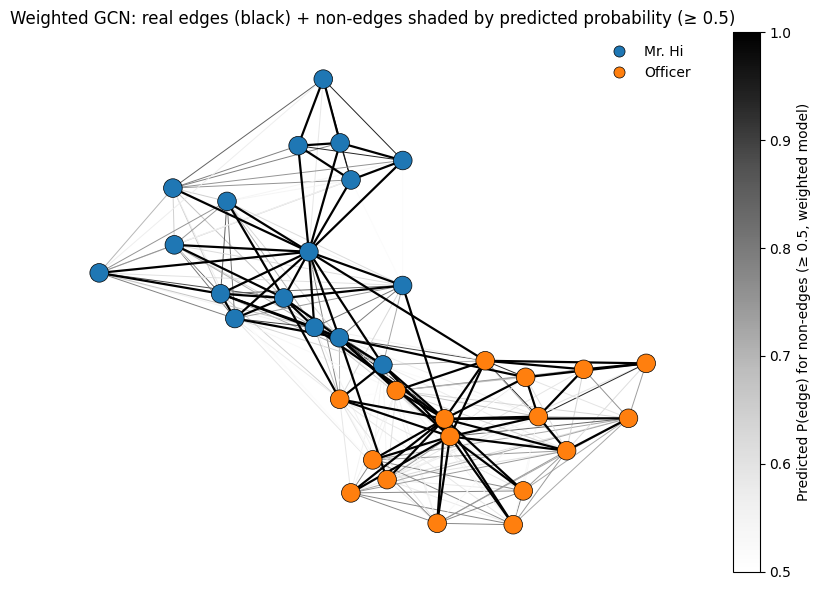

In [11]:
pos_w = pos
non_edges_w, probs_w = [], []
for i in range(N):
    for j in range(i + 1, N):
        if not Gw.has_edge(i, j):
            p = torch.sigmoid((z_eval_w[i] * z_eval_w[j]).sum()).item()
            non_edges_w.append((i, j))
            probs_w.append(p)

edges_probs_w = [(e, p) for e, p in zip(non_edges_w, probs_w) if p >= 0.5]
non_edges_w_draw = [e for e, _ in edges_probs_w]
probs_w_draw = [p for _, p in edges_probs_w]

node_colors_w = ['tab:blue' if int(club_idx[i].item()) == 0 else 'tab:orange' for i in range(N)]
Hw = nx.Graph(); Hw.add_nodes_from(Gw.nodes()); Hw.add_edges_from(non_edges_w_draw)

fig, ax = plt.subplots(figsize=(8, 6))
nx.draw_networkx_edges(Hw, pos_w, edgelist=non_edges_w_draw, edge_color=probs_w_draw,
             edge_cmap=plt.cm.Greys, edge_vmin=0.5, edge_vmax=1.0, width=0.7, alpha=0.9, ax=ax)
nx.draw_networkx_edges(Gw, pos_w, edgelist=list(Gw.edges()), edge_color="black", width=1.6, ax=ax)
nx.draw_networkx_nodes(Gw, pos_w, node_color=node_colors_w, edgecolors="black", linewidths=0.5, node_size=180, ax=ax)
sm = mpl.cm.ScalarMappable(cmap=plt.cm.Greys, norm=plt.Normalize(vmin=0.5, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Predicted P(edge) for non-edges (≥ 0.5, weighted model)")
ax.legend(handles=[
  Line2D([0], [0], marker='o', color='w', label='Mr. Hi',
       markerfacecolor='tab:blue', markeredgecolor='black', markeredgewidth=0.5, markersize=8),
  Line2D([0], [0], marker='o', color='w', label='Officer',
       markerfacecolor='tab:orange', markeredgecolor='black', markeredgewidth=0.5, markersize=8)
], loc='best', frameon=False)
ax.set_title("Weighted GCN: real edges (black) + non-edges shaded by predicted probability (≥ 0.5)")
ax.axis("off")
plt.tight_layout(); plt.show()

In [12]:
import pandas as pd
import networkx as nx

nodes_df = pd.read_csv("D:\\Academic\\Master\\ST5225\\nodes_full.csv")
edges_df = pd.read_csv("D:\\Academic\\Master\\ST5225\\edges_full.csv")

G = nx.Graph()
for _, row in nodes_df.iterrows():
    nid = int(row['ID'])
    lvl = row.get("level")
    lvl = None if pd.isna(lvl) else int(lvl)
    G.add_node(nid, Id=nid, **{"class": row.get("class"), "gender": row.get("gender"), "level": lvl})

for _, row in edges_df.iterrows():
    u = int(row['ID1'])
    v = int(row['ID2'])
    w = int(row.get("weight", 1))
    G.add_edge(u, v, weight=w)

unknown = [n for n, d in G.nodes(data=True) if str(d.get("gender")) == "Unknown"]
G.remove_nodes_from(unknown)
G = G.subgraph([n for n, d in G.nodes(data=True) if str(d.get("gender")) in ("M", "F")]).copy()

print(f"High-school graph -> Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")


High-school graph -> Nodes: 227, Edges: 7584


In [13]:
import torch
import networkx as nx
from torch_geometric.utils import to_undirected

classes = sorted({str(G.nodes[n].get("class")) for n in G.nodes()})
class_to_idx = {c: i for i, c in enumerate(classes)}
levels = [G.nodes[n].get("level") for n in G.nodes()]
unique_levels = sorted({int(l) for l in levels if l is not None})
level_to_idx = {l: i+1 for i, l in enumerate(unique_levels)}

nodes = sorted(G.nodes())
idx_df = {n: i for i, n in enumerate(nodes)}
N = len(nodes)

class_idx = torch.tensor([class_to_idx[str(G.nodes[n].get("class"))] for n in nodes], dtype=torch.long)
level_idx = torch.tensor([level_to_idx.get(G.nodes[n].get("level"), 0) for n in nodes], dtype=torch.long)

deg = dict(G.degree())
tri = nx.triangles(G)
clu = nx.clustering(G)
bet = nx.betweenness_centrality(G, normalized=True)
clo = nx.closeness_centrality(G)

scalars = torch.stack([
    torch.tensor([deg[n] for n in nodes], dtype=torch.float32),
    torch.tensor([tri[n] for n in nodes], dtype=torch.float32),
    torch.tensor([clu[n] for n in nodes], dtype=torch.float32),
    torch.tensor([bet[n] for n in nodes], dtype=torch.float32),
    torch.tensor([clo[n] for n in nodes], dtype=torch.float32),
], dim=1)

mins = scalars.min(dim=0).values
maxs = scalars.max(dim=0).values
scalars = (scalars - mins) / (maxs - mins + 1e-12)

gende_to_idx = {'F': 0, 'M': 1}
y = torch.tensor([gende_to_idx[str(G.nodes[n].get("gender"))] for n in nodes], dtype=torch.long)

import torch
edges = torch.tensor(
    [(idx_df[u], idx_df[v]) for u, v in G.edges()],
    dtype=torch.long
).t().contiguous()
edge_w = torch.tensor(
    [G[u][v].get("weight", 1) for u, v in G.edges()],
    dtype=torch.float32
)
edge_index, edge_w = to_undirected(edges, num_nodes=N, edge_attr=edge_w)

perm = torch.randperm(N)
n_train = int(0.75 * N)
train_idx = perm[:n_train]
test_idx = perm[n_train:]
train_mask = torch.zeros(N, dtype=torch.bool)
train_mask[train_idx] = True
test_mask = torch.zeros(N, dtype=torch.bool)
test_mask[test_idx] = True

In [14]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import GCNConv

class HSNet(nn.Module):
    def __init__(self, num_classes, num_levels, scalar_dim=5, hidden_dim=10, dropout=0.1):
        super().__init__()
        self.class_emb = nn.Embedding(num_classes, hidden_dim)
        self.level_emb = nn.Embedding(num_levels + 1, hidden_dim)
        self.in_lin = nn.Linear(hidden_dim*2+scalar_dim, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim, add_self_loops=True)
        self.conv2 = GCNConv(hidden_dim, hidden_dim, add_self_loops=True)
        self.conv3 = GCNConv(hidden_dim, hidden_dim, add_self_loops=True)
        self.drop = nn.Dropout(p=dropout)
        self.head = nn.Linear(hidden_dim*3, 2)
    def forward(self, class_idx, level_idx, scalars, edge_index, edge_weight=None):
        x = torch.cat([
            self.class_emb(class_idx),
            self.level_emb(level_idx),
            scalars
        ], dim=1)
        x = F.relu(self.in_lin(x))
        x = self.drop(x)
        x1 = F.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x1 = self.drop(x1)
        x2 = F.relu(self.conv2(x1, edge_index, edge_weight=edge_weight))
        x2 = self.drop(x2)
        x3 = F.relu(self.conv3(x2, edge_index, edge_weight=edge_weight))
        x3 = self.drop(x3)
        z = torch.cat([x1, x2, x3], dim=1)
        return self.head(z)

model = HSNet(num_classes=len(class_to_idx), num_levels=len(unique_levels), scalar_dim=scalars.size(1), hidden_dim=10, dropout=0.3)
opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
crit = nn.CrossEntropyLoss()

for epoch in range(20000):
    model.train()
    opt.zero_grad()
    logits = model(class_idx, level_idx, scalars, edge_index, edge_weight=edge_w)
    loss = crit(logits[train_mask], y[train_mask])
    loss.backward()
    opt.step()
    if epoch % 1000 == 0:
        with torch.no_grad():
            acc_tr = (logits[train_mask].argmax(dim=1) == y[train_mask]).float().mean().item()
        print(f"epoch {epoch:4d} | train loss {loss.item():.4f} | train acc {acc_tr:.4f}")

model.eval()
with torch.no_grad():
    logits = model(class_idx, level_idx, scalars, edge_index, edge_weight=edge_w)
    acc_tr = (logits[train_mask].argmax(dim=1) == y[train_mask]).float().mean().item()
print(f"Final training accuracy (train 75%): {acc_tr:.4f}")

epoch    0 | train loss 0.6934 | train acc 0.4941
epoch 1000 | train loss 0.5020 | train acc 0.7412
epoch 2000 | train loss 0.4795 | train acc 0.7706
epoch 3000 | train loss 0.4820 | train acc 0.7765
epoch 4000 | train loss 0.4748 | train acc 0.7471
epoch 5000 | train loss 0.4307 | train acc 0.7824
epoch 6000 | train loss 0.4152 | train acc 0.8000
epoch 7000 | train loss 0.5218 | train acc 0.7471
epoch 8000 | train loss 0.4617 | train acc 0.7647
epoch 9000 | train loss 0.4537 | train acc 0.7471
epoch 10000 | train loss 0.5082 | train acc 0.6941
epoch 11000 | train loss 0.4432 | train acc 0.8000
epoch 12000 | train loss 0.5271 | train acc 0.7412
epoch 13000 | train loss 0.4387 | train acc 0.7765
epoch 14000 | train loss 0.4386 | train acc 0.8059
epoch 15000 | train loss 0.4601 | train acc 0.7588
epoch 16000 | train loss 0.4641 | train acc 0.7647
epoch 17000 | train loss 0.4415 | train acc 0.7882
epoch 18000 | train loss 0.4934 | train acc 0.7235
epoch 19000 | train loss 0.4972 | train a

In [15]:
import numpy as np
import torch
import torch.nn.functional as F

def count_parameters(m):
    total = 0
    per_module = {}
    print("Parameters by tensor:")
    for name, p in m.named_parameters():
        n = p.numel()
        total += n
        mod = name.split('.')[0]
        per_module[mod] = per_module.get(mod, 0) + n
        print(f"  {name:35s} {tuple(p.shape)} -> {n}")
    print("\nParameters by top-level module:")
    for mod, cnt in sorted(per_module.items(), key=lambda x: -x[1]):
        print(f"  {mod:15s} -> {cnt}")
    print(f"Total parameters: {total}")

count_parameters(model)

Parameters by tensor:
  class_emb.weight                    (10, 10) -> 100
  level_emb.weight                    (6, 10) -> 60
  in_lin.weight                       (10, 25) -> 250
  in_lin.bias                         (10,) -> 10
  conv1.bias                          (10,) -> 10
  conv1.lin.weight                    (10, 10) -> 100
  conv2.bias                          (10,) -> 10
  conv2.lin.weight                    (10, 10) -> 100
  conv3.bias                          (10,) -> 10
  conv3.lin.weight                    (10, 10) -> 100
  head.weight                         (2, 30) -> 60
  head.bias                           (2,) -> 2

Parameters by top-level module:
  in_lin          -> 260
  conv1           -> 110
  conv2           -> 110
  conv3           -> 110
  class_emb       -> 100
  head            -> 62
  level_emb       -> 60
Total parameters: 812


In [17]:
with torch.no_grad():
    emb_c = model.class_emb(class_idx)
    emb_l = model.level_emb(level_idx)
    xcat = torch.cat([emb_c, emb_l, scalars], 1)
    x0 = F.relu(model.in_lin(xcat))
    x1 = F.relu(model.conv1(x0, edge_index, edge_weight=edge_w))
    x2 = F.relu(model.conv2(x1, edge_index, edge_weight=edge_w))
    x3 = F.relu(model.conv3(x2, edge_index, edge_weight=edge_w))
    z = torch.cat([x1, x2, x3], 1)
    logits = model.head(z)

    print("\nTensor shapes:")
    print("  class_emb:", tuple(emb_c.shape))
    print("  level_emb:", tuple(emb_l.shape))
    print("  concat [class_emb, level_emb, scalars]:", tuple(xcat.shape))
    print("  after in_lin+ReLU:", tuple(x0.shape))
    print("  x1 (GCN1+ReLU):", tuple(x1.shape))
    print("  x2 (GCN2+ReLU):", tuple(x2.shape))
    print("  x3 (GCN3+ReLU):", tuple(x3.shape))
    print("  z = concat[x1,x2,x3]:", tuple(z.shape))
    print("  logits:", tuple(logits.shape))




Tensor shapes:
  class_emb: (227, 10)
  level_emb: (227, 10)
  concat [class_emb, level_emb, scalars]: (227, 25)
  after in_lin+ReLU: (227, 10)
  x1 (GCN1+ReLU): (227, 10)
  x2 (GCN2+ReLU): (227, 10)
  x3 (GCN3+ReLU): (227, 10)
  z = concat[x1,x2,x3]: (227, 30)
  logits: (227, 2)


In [18]:
with torch.no_grad():
    pred = logits.argmax(1)
    test_acc = (pred[test_mask] == y[test_mask]).float().mean().item()

cm = np.zeros((2, 2), dtype=int)
for t, p in zip(y[test_mask].tolist(), pred[test_mask].tolist()):
    cm[t][p] += 1

print(f"\nTest accuracy (25%): {test_acc:.4f}")
print("Confusion matrix (rows=true, cols=pred) on test set:")
print("          Pred F    Pred M")
print(f"True F   {cm[0,0]:7d}   {cm[0,1]:7d}")
print(f"True M   {cm[1,0]:7d}   {cm[1,1]:7d}")


Test accuracy (25%): 0.7895
Confusion matrix (rows=true, cols=pred) on test set:
          Pred F    Pred M
True F        22         3
True M         9        23
